In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from matplotlib.colors import LogNorm

In [3]:
fits_filex='hlsp_frontier_model_abell2744_williams_v4_x-pixels-deflect.fits'
fits_filey='hlsp_frontier_model_abell2744_williams_v4_y-pixels-deflect.fits'
img_file='hlsp_frontier_model_abell2744_williams_v4_kappa.fits'
mag_file='hlsp_frontier_model_abell2744_williams_v4_z01-magnif.fits'
hdul = fits.open(fits_filex)
hdul1 = fits.open(fits_filey)
hdul_mag = fits.open(mag_file)
hdul_img = fits.open(img_file)


In [4]:
datax = hdul[0].data

datay = hdul1[0].data

data_img = hdul_img[0].data

#array_data = np.zeros((datax.shape[0],datax.shape[1]))
#array_data[100:160, 100:160]=datax[100:160, 100:160]

data_mag = hdul_mag[0].data
hdul.close()
hdul1.close()
hdul_img.close()

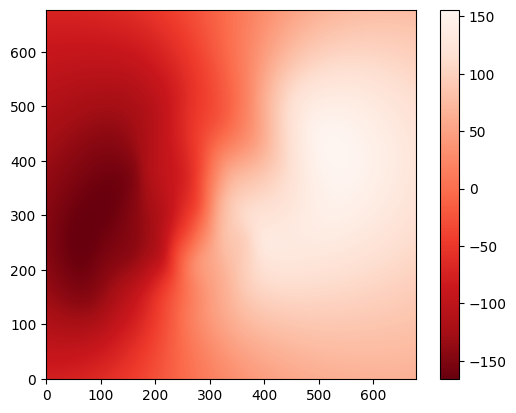

In [5]:
plt.imshow(datax, cmap='Reds_r')
plt.gca().invert_yaxis()
plt.colorbar()

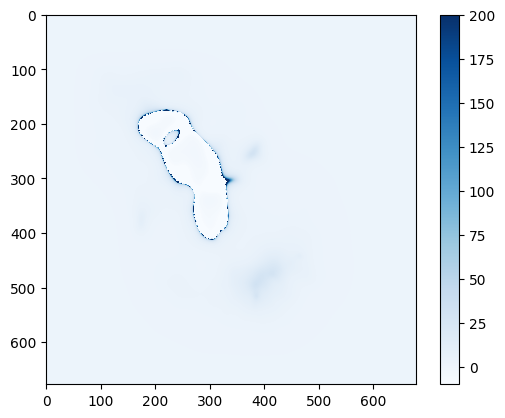

In [6]:
plt.imshow(data_mag, cmap='Blues',vmin=-10, vmax=200)
plt.colorbar()


68


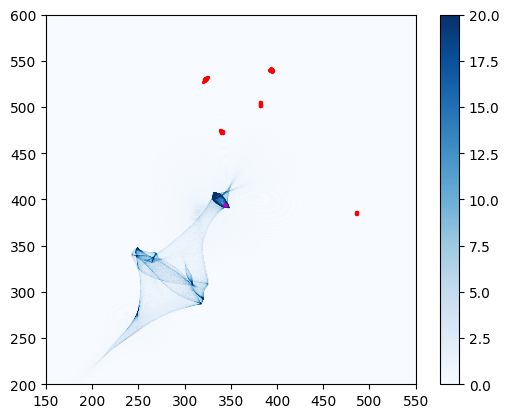

In [7]:
size = datax.shape[0]

array_test = np.zeros((size,size))
img_coord_in_src_coord = [[[] for _ in range(678)] for _ in range(678)]
for i in range(0,678):
    for j in range(0,678):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        #array_test[ceil(ycoord),ceil(xcoord)] += data_img[i,j]*ydec*xdec
        #array_test[ceil(ycoord),floor(xcoord)] += data_img[i,j]*ydec*(1-xdec)
        #array_test[floor(ycoord),ceil(xcoord)] += data_img[i,j]*(1-ydec)*xdec
        array_test[yfloor,xfloor] += data_img[i,j]*(1-ydec)*(1-xdec)
        #img_coord_in_src_coord[floor(ycoord)][floor(xcoord)].append([i,j])


#gaussian circle
'''mean = [260, 330] #(x,y)
cov = [[40, 0], [0, 40]]

# Generate a grid of (x, y) coordinates
x, y = np.meshgrid(np.linspace(0, size, size), np.linspace(0, size, size))

# Generate a 2D Gaussian distribution over the grid
d = np.dstack([x, y])
gaussian_circle = np.exp(-0.5 * (np.einsum('...k,kl,...l->...', d - mean, np.linalg.inv(cov), d - mean)))
circle_coords = np.argwhere(gaussian_circle > 0.5)

# radius
from scipy.ndimage import distance_transform_edt as distance
radius = max(circle_coords[:,1])-mean[0]
print(f'Radius: {radius}')'''



'''#specific method for perfect circle
for i in range(size):
    for j in range(size):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        dist = np.sqrt((ycoord-center[1])**2+(xcoord-center[0])**2)
        if dist <= radius:
            scatterx.append(j)
            scattery.append(i)
            n+=1'''
            
# point source            
coord = (343.2,394.4)
coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
y_round, x_round = round(coord[1]), round(coord[0])

# Pre-calculate possible matching rounded values for efficiency
y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

coordinates = []
n = 0

# Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
for i in range(size):
    for j in range(size):
        ycoord, xcoord = i - datay[i, j], j - datax[i, j]
        if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
            coordinates.append((j, i))  # (x, y)
            
            n += 1

plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=2)
plt.scatter(coord[0], coord[1], c='m', s=5)
print(n)


'''for (i,j) in circle_coords:
    
    for point in img_coord_in_src_coord[i][j]:
        n+=1
        scatterx.append(point[1])
        scattery.append(point[0])'''


plt.xlim(150,550)
plt.ylim(200,600)
plt.imshow(array_test, cmap='Blues', vmax=20)
plt.colorbar()



Number of pixels: [7, 12, 15, 18, 16]


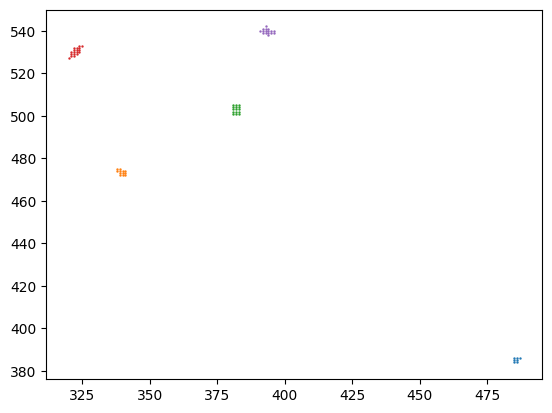

In [8]:
#Clustering
from sklearn.cluster import DBSCAN

coordinates = np.array(coordinates)

# Apply DBSCAN clustering
# eps and min_samples need to be chosen based on your specific data
dbscan = DBSCAN(eps=6, min_samples=1).fit(coordinates)

# Extract labels
labels = dbscan.labels_

# Separate coordinates into arrays for each image
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]

# images now contains separate arrays for each detected image
# convert the dictionary images to list
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=0.5)
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')

In [9]:
# interpolate the deflected angle given the image pos
def src_pos_test_interpolate(x,y, alpha_x= datax, alpha_y = datay):  #(x,y) is img_guess
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array([alpha_x[ceil(y), floor(x)], alpha_y[ceil(y), floor(x)]]) #to match (y,x) of alpha grid
    top_right = np.array([alpha_x[ceil(y), ceil(x)], alpha_y[ceil(y), ceil(x)]])
    bottom_left = np.array([alpha_x[floor(y), floor(x)], alpha_y[floor(y), floor(x)]])
    bottom_right = np.array([alpha_x[floor(y), ceil(x)], alpha_y[floor(y), ceil(x)]])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    alpha = top * dy + bottom *(1 - dy)
    src_pos = np.array([x-alpha[0], y-alpha[1]])
    return src_pos 
                                             
def diff_interpolate (img_guess):
    return np.sqrt((src_pos_test_interpolate(img_guess[0],img_guess[1])[0]-coord[0])**2 + (src_pos_test_interpolate(img_guess[0],img_guess[1])[1]-coord[1])**2)



485 487 384 386 [486.44313346 386.1703372 ] 1.2771779177055145e-07
338 341 472 475 [341.36941717 473.5715475 ] 1.084152026836052e-06
381 383 501 505 [381.27701556 500.8361901 ] 3.95631272493382e-06
320 325 527 533 [324.03328203 532.78903956] 1.5406490120315944e-06
391 396 538 542 [393.80493438 541.24297125] 6.345910490877883e-07


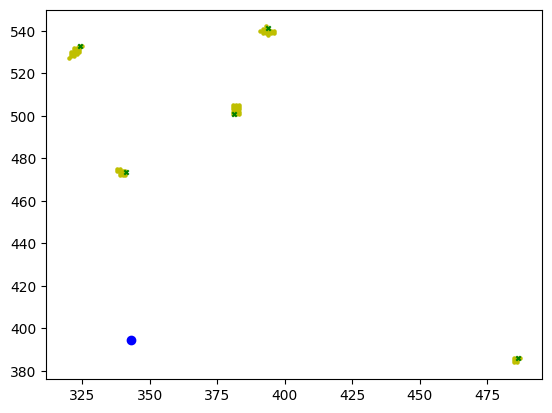

In [11]:
import scipy.optimize._minimize as minimize
# minimum distance between the source position and the guess source positions deflected by mutiple images
# expect partition of the images and search for 1 sol for 1 image
plt.scatter(coord[0], coord[1], c='b')
plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='y', s=5)
# find maximum x and y coordinates of the image[i]
for i in range(len(images)):
    x_max, x_min = np.max(images[i][:,0]), np.min(images[i][:,0])
    y_max, y_min = np.max(images[i][:,1]), np.min(images[i][:,1])
    img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
    pos = minimize.minimize(diff_interpolate, img_guess, bounds =[(x_min-5, x_max+5), (y_min-5, y_max+5)], method='Nelder-Mead', tol=1e-6) # the 1 is for wider boundary
    print(x_min, x_max, y_min, y_max, pos.x, diff_interpolate(pos.x))
    plt.scatter(pos.x[0], pos.x[1], c='g', s=10, marker='x')


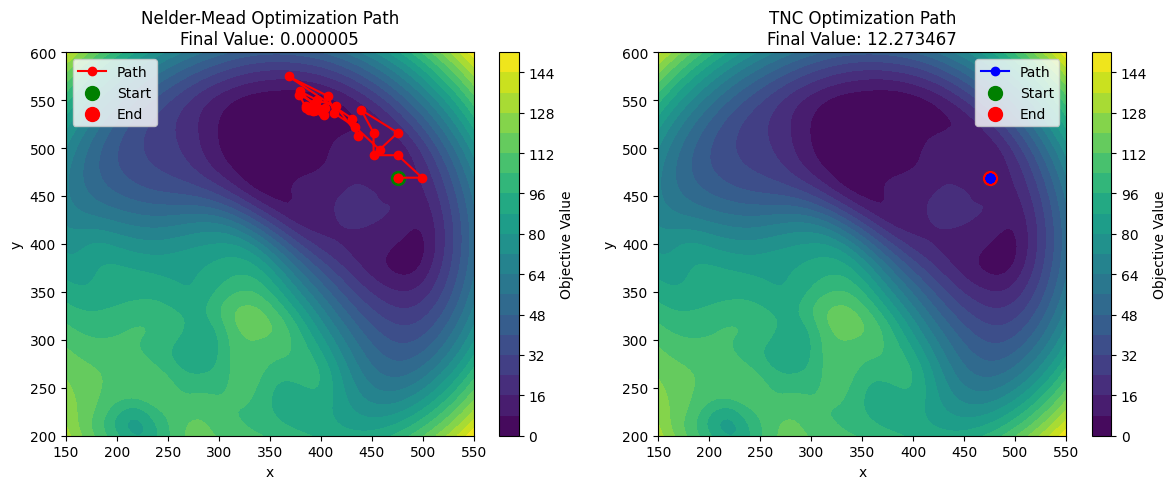

Nelder-Mead result: [393.80495277 541.24297142], value: 4.8209267934219604e-06
TNC result: [475.51032186 469.06216403], value: 12.27346745255243


In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def optimize_with_path(method, x0, bounds):
    path = [x0]
    
    def objective_wrapper(x):
        path.append(x)
        return diff_interpolate(x)
    
    result = minimize(objective_wrapper, x0, method=method, bounds=bounds)
    return result, np.array(path)

# Set up the problem
bounds = [(150, 550), (200, 600)]
x0 = np.random.uniform(bounds[0][0], bounds[0][1]), np.random.uniform(bounds[1][0], bounds[1][1])

# Run optimizations
nelder_mead_result, nelder_mead_path = optimize_with_path('Nelder-Mead', x0, bounds)
tnc_result, tnc_path = optimize_with_path('TNC', x0, bounds)

# Create a contour plot of the objective function
x = np.linspace(bounds[0][0], bounds[0][1], 100)
y = np.linspace(bounds[1][0], bounds[1][1], 100)
X, Y = np.meshgrid(x, y)
Z = np.array([diff_interpolate([xi, yi]) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

# Plot
plt.figure(figsize=(12, 5))

# Nelder-Mead path
plt.subplot(121)
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Objective Value')
plt.plot(nelder_mead_path[:, 0], nelder_mead_path[:, 1], 'ro-', label='Path')
plt.scatter(nelder_mead_path[0, 0], nelder_mead_path[0, 1], c='g', s=100, label='Start')
plt.scatter(nelder_mead_path[-1, 0], nelder_mead_path[-1, 1], c='r', s=100, label='End')
plt.title(f'Nelder-Mead Optimization Path\nFinal Value: {nelder_mead_result.fun:.6f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# TNC path
plt.subplot(122)
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Objective Value')
plt.plot(tnc_path[:, 0], tnc_path[:, 1], 'bo-', label='Path')
plt.scatter(tnc_path[0, 0], tnc_path[0, 1], c='g', s=100, label='Start')
plt.scatter(tnc_path[-1, 0], tnc_path[-1, 1], c='r', s=100, label='End')
plt.title(f'TNC Optimization Path\nFinal Value: {tnc_result.fun:.6f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

# Print results
print(f"Nelder-Mead result: {nelder_mead_result.x}, value: {nelder_mead_result.fun}")
print(f"TNC result: {tnc_result.x}, value: {tnc_result.fun}")

In [ ]:
# compare with lenstronomy result


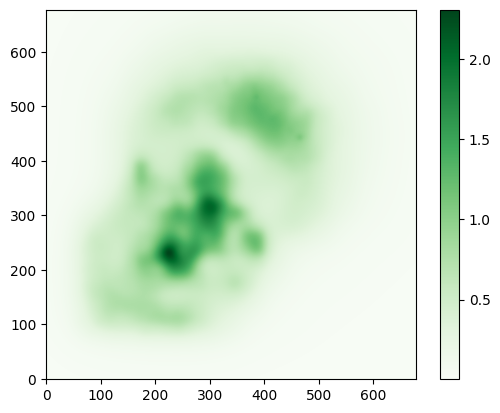

In [9]:
plt.imshow(data_img, cmap='Greens')
plt.colorbar()
plt.gca().invert_yaxis()

In [1]:
def src_pos_test_interpolate(x,y, alpha_x= datax, alpha_y = datay):  #(x,y) is img_guess
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array([alpha_x[ceil(y), floor(x)], alpha_y[ceil(y), floor(x)]]) #to match (y,x) of alpha grid
    top_right = np.array([alpha_x[ceil(y), ceil(x)], alpha_y[ceil(y), ceil(x)]])
    bottom_left = np.array([alpha_x[floor(y), floor(x)], alpha_y[floor(y), floor(x)]])
    bottom_right = np.array([alpha_x[floor(y), ceil(x)], alpha_y[floor(y), ceil(x)]])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    alpha = top * dy + bottom *(1 - dy)
    src_pos = np.array([x-alpha[0], y-alpha[1]])
    return src_pos 
                                             
def diff_interpolate (img_guess):
    return np.sqrt((src_pos_test_interpolate(img_guess[0],img_guess[1])[0]-coord[0])**2 + (src_pos_test_interpolate(img_guess[0],img_guess[1])[1]-coord[1])**2)

NameError: name 'alpha_x_2d' is not defined